# Alzheimer experiment 
In this notebook, we are experimenting with a dataset of brain MRI images of patients, diagnosed with early stages of Alzheimer's disease. We are measuring how changes of the structure of imported neural network architecture will affect the accuracy and learning speed of the model. We also want to reduce the overfitting. We are using VGG19 architecture. First we run the whole CNN end to end. Then we freeze some convolutional base layers and run the rest. At last we examine the model on the test part of the dataset.
The task is very slow and expensive, so we recommend to run it on GPU.
 

In [1]:
# Imports

import tensorflow as tf
import keras
import numpy as np
import pickle
import os
import time
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg19 import VGG19 as VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

start = time.time()

Using TensorFlow backend.


In [22]:
# Params

dim = (176,208)               
test_split_percent = 0.1      
validation_split_percent = 0.2
zoom = [.99,1.01]            
bright_range = [0.8,1.2]       
lr = 0.0001                   
batch = 5000                    
eps = 20                     
momentum = 0.9
## weights=ImageNet?


# Paths

path_train = "C:/Users/flang/Desktop/DATASETS/Alzheimer/train/"
path_test = "C:/Users/flang/Desktop/DATASETS/Alzheimer/test/"

In [3]:
# Image preprocessing 
# balancing and augmentation should be used only in training dataset

train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)
train_data_gen = train_dr.flow_from_directory(directory=path_train,target_size=dim,
                                              batch_size=batch)

test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory=path_test,target_size=dim,batch_size=batch,
                                           shuffle = False)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
# Data and labels into numpy arrays

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

In [5]:
# Concatenate data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [6]:
# train_data, train_labels, test_data, test_labels split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


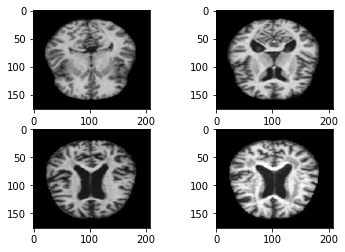

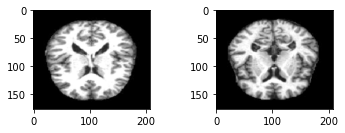

In [7]:
# Check images

plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[18,:,:,:])

## VGG19 Model

In [8]:
# VGG19 net_model

net_model = VGG19(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max')


In [14]:
# New densely connected top instead of the original one

flatten1 = Flatten()(net_model.output)
den1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flatten1)
drpt1 = Dropout(0.25)(den1)                                                  
output = Dense(4,activation='sigmoid')(drpt1) # softmax used in the 1st round of training                              
net_model = Model(inputs=net_model.inputs, outputs=output)

In [19]:
# Function for changing the structure of the network

for layer in net_model.layers[1:17]:
    layer.trainable = False
for i, layer in enumerate(net_model.layers):
   print(i, layer.name)   
for layer in net_model.layers:
    print(layer, layer.trainable)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_max_pooling2d
23 flatten
24 dense
25 dropout
26 dense_1
27 flatten_1
28 dense_2
29 dropout_1
30 dense_3
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000022D17606248> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022CE5691448> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022CE4C49788> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000022D188B7248> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022D188AA588> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022D188BCCC8> False
<tensorflow.python.

In [21]:

net_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0   

In [20]:
# Compile the model

opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 

net_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [23]:
# Train the model

model_history = net_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=eps,batch_size=20,shuffle=True)
scores = net_model.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Train on 4395 samples, validate on 628 samples
Epoch 1/20
4395/4395 [==============================] - 62s 14ms/sample - loss: 0.7924 - accuracy: 0.7980 - val_loss: 0.3914 - val_accuracy: 0.9697
Epoch 2/20
4395/4395 [==============================] - 47s 11ms/sample - loss: 0.2237 - accuracy: 0.9884 - val_loss: 0.1852 - val_accuracy: 0.9697
Epoch 3/20
4395/4395 [==============================] - 47s 11ms/sample - loss: 0.1042 - accuracy: 0.9898 - val_loss: 0.1446 - val_accuracy: 0.9697
Epoch 4/20
4395/4395 [==============================] - 46s 11ms/sample - loss: 0.0691 - accuracy: 0.9923 - val_loss: 0.1311 - val_accuracy: 0.9713
Epoch 5/20
4395/4395 [==============================] - 47s 11ms/sample - loss: 0.0525 - accuracy: 0.9943 - val_loss: 0.1264 - val_accuracy: 0.9793
Epoch 6/20
4395/4395 [==============================] - 46s 10ms/sample - loss: 0.0425 - accuracy: 0.9966 - val_loss: 0.1226 - val_accuracy: 0.9793
Epoch 7/20
4395/4395 [==============================] - 47s 11ms/

In [24]:
# Test the model

train_scores = net_model.evaluate(train_data, train_labels)
val_scores = net_model.evaluate(val_data,val_labels)
test_scores = net_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

1256/1256 [==============================] - 17s 13ms/sample - loss: 0.0894 - accuracy: 0.9817
Train Accuracy: 100.00%
Validation Accuracy: 97.61%
Test Accuracy: 98.17%


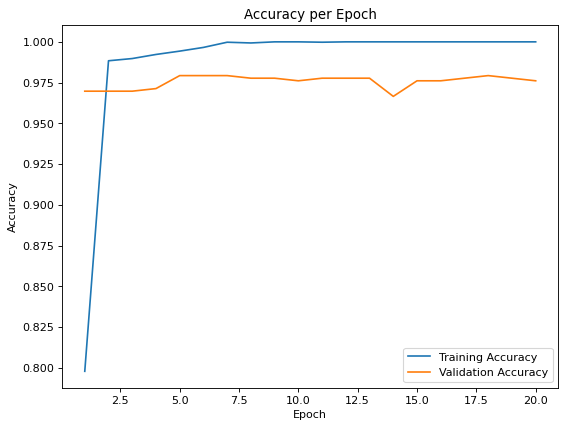

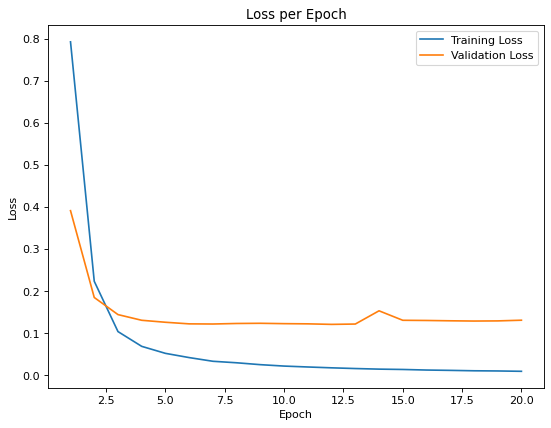

image dimensions:  (176, 208)
validation split percentage:  0.2
zoom:  [0.99, 1.01]
Learning Rate:  0.0001
batch size:  5000
epochs:  20
brightness range:  [0.8, 1.2]
Total Time Elapsed = 113 minutes


In [28]:
# Plot accuracy after retraining

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Accuracy per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Plot loss after retraining

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Loss per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'], label = 'Training Loss')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_loss'], label = 'Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

print('image dimensions: ',dim)
print('validation split percentage: ',validation_split_percent)
print('zoom: ',zoom)
print('Learning Rate: ',lr)
print('batch size: ',batch)
print('epochs: ',eps)
print('brightness range: ',bright_range)
end = time.time()
print('Total Time Elapsed = %.2d minutes'%((end - start)/60))

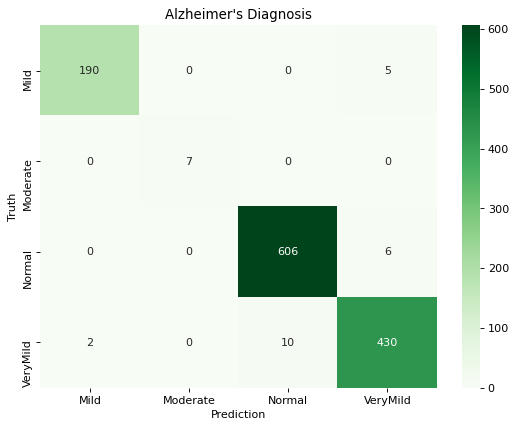

In [30]:
# Confusion matrix

predic = net_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)